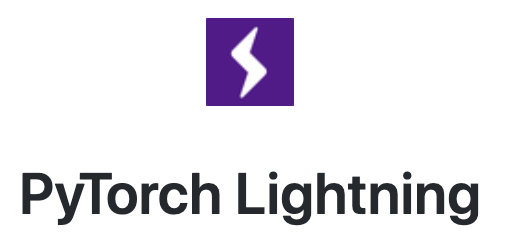

# Live DEMO

Here are four examples using Lightning.

1. MNIST
2. GAN
3. Finetuning a Transformer from Huggingface
4. DQN

--- 
### Setup  
Lightning is easy to use. Simply ```pip install pytorch-lightning```

In [ ]:
! pip install pytorch-lightning==0.8.3 --upgrade --silent

In [ ]:
import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

--- 
## MNIST hello world

## Simplest example

Here's the simplest most minimal example with just a training loop (no validation, no testing).


In [ ]:
class MNISTModel(pl.LightningModule):

    def __init__(self):
        super(MNISTModel, self).__init__()
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self(x), y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [ ]:
train_loader = DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

mnist_model = MNISTModel()
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=20)    
trainer.fit(mnist_model, train_loader)  

### 1. LightningModule
Each project goes into a LightningModule.
This module houses:
1. Model definition (__init__)
2. Computations (forward)
3. What happens inside the training loop (training_step)
4. What happens inside the validation loop (validation_step)
5. What optimizer(s) to use (configure_optimizers)
6. What data to use (train_dataloader, val_dataloader, test_dataloader)

In [ ]:
import os

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

class MNISTModel(pl.LightningModule):

    def __init__(self):
        super(MNISTModel, self).__init__()
        # not the best model...
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        # called with self(x)
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'val_loss': F.cross_entropy(y_hat, y)}

    def validation_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.cross_entropy(y_hat, y)}

    def test_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.02)

    def train_dataloader(self):
        # REQUIRED
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor()), batch_size=32)

### 2. Trainer
The trainer is where the magic happens!
Feed ANY LightningModule to a trainer to train the model.

In [ ]:
mnist_model = MNISTModel()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1)    
trainer.fit(mnist_model)   

### Testing

In [ ]:
trainer.test()

### Plotting

Plot the results

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

By using the trainer you automatically get:
1. Tensorboard logging
2. Model checkpointing
3. Training and validation loop
4. early-stopping

### Bonus
In fact, if you keep calling fit, it'll keep training the model where it left off!

In [ ]:
trainer.fit(mnist_model)

---
## GAN Example

How to train a GAN!

Main takeaways:
1. Generator and discriminator are arbitraty PyTorch modules.
2. training_step does both the generator and discriminator training.

#### A. Generator

In [ ]:
"""
To run this template just do:
python gan.py
After a few epochs, launch tensorboard to see the images being generated at every batch.
tensorboard --logdir default
"""
import os
from argparse import ArgumentParser
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

import pytorch_lightning as pl


class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

### B. Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

### C. GAN

In [ ]:
class GAN(pl.LightningModule):

    def __init__(self, hparams):
        super(GAN, self).__init__()
        self.hparams = hparams

        # networks
        mnist_shape = (1, 28, 28)
        self.generator = Generator(latent_dim=hparams.latent_dim, img_shape=mnist_shape)
        self.discriminator = Discriminator(img_shape=mnist_shape)

        # cache for generated images
        self.generated_imgs = None
        self.last_imgs = None

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_nb, optimizer_idx):
        imgs, _ = batch
        self.last_imgs = imgs

        # train generator
        if optimizer_idx == 0:
            # sample noise
            z = torch.randn(imgs.shape[0], self.hparams.latent_dim)

            # match gpu device (or keep as cpu)
            if self.on_gpu:
                z = z.cuda(imgs.device.index)

            # generate images
            self.generated_imgs = self(z)

            # log sampled images
            # sample_imgs = self.generated_imgs[:6]
            # grid = torchvision.utils.make_grid(sample_imgs)
            # self.logger.experiment.add_image('generated_images', grid, 0)

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(imgs.size(0), 1)
            if self.on_gpu:
              valid = valid.cuda(imgs.device.index)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self.generated_imgs), valid)
            tqdm_dict = {'g_loss': g_loss}
            output = OrderedDict({
                'loss': g_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(imgs.size(0), 1)
            if self.on_gpu:
              valid = valid.cuda(imgs.device.index)

            real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

            # how well can it label as fake?
            fake = torch.zeros(imgs.size(0), 1)
            if self.on_gpu:
              fake = fake.cuda(imgs.device.index)

            fake_loss = self.adversarial_loss(
                self.discriminator(self.generated_imgs.detach()), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            tqdm_dict = {'d_loss': d_loss}
            output = OrderedDict({
                'loss': d_loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def train_dataloader(self):
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([0.5], [0.5])])
        dataset = MNIST(os.getcwd(), train=True, download=True, transform=transform)
        return DataLoader(dataset, batch_size=self.hparams.batch_size)

    def on_epoch_end(self):
        z = torch.randn(8, self.hparams.latent_dim)
        # match gpu device (or keep as cpu)
        if self.on_gpu:
            z = z.cuda(self.last_imgs.device.index)

        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image(f'generated_images', grid, self.current_epoch)

### D. Trainer

Here we fake using argparse

In [ ]:
from argparse import Namespace

args = {
    'batch_size': 32,
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'latent_dim': 100
}
hparams = Namespace(**args)

In [ ]:
gan_model = GAN(hparams)

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1)    
trainer.fit(gan_model)   

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

---  
## BERT example
BERT + Lightning

In [ ]:
! pip install transformers

#### Data download + processing

Let's grab the correct data

In [ ]:
from transformers.data.processors.glue import MnliProcessor
import torch
from transformers import (
    BertModel,
    BertTokenizer
)

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert = BertModel.from_pretrained('bert-base-cased', output_attentions=True)

In [ ]:
import pandas as pd
import os
import sys
import shutil
import argparse
import tempfile
import urllib.request
import zipfile

TASKS = ["CoLA", "SST", "MRPC", "QQP", "STS", "MNLI", "SNLI", "QNLI", "RTE", "WNLI", "diagnostic"]
TASK2PATH = {
    "CoLA": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FCoLA.zip?alt=media&token=46d5e637-3411-4188-bc44-5809b5bfb5f4",  # noqa
    "SST": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSST-2.zip?alt=media&token=aabc5f6b-e466-44a2-b9b4-cf6337f84ac8",  # noqa
    "MRPC": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc",  # noqa
    "QQP": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQQP-clean.zip?alt=media&token=11a647cb-ecd3-49c9-9d31-79f8ca8fe277",  # noqa
    "STS": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSTS-B.zip?alt=media&token=bddb94a7-8706-4e0d-a694-1109e12273b5",  # noqa
    "MNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FMNLI.zip?alt=media&token=50329ea1-e339-40e2-809c-10c40afff3ce",  # noqa
    "SNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSNLI.zip?alt=media&token=4afcfbb2-ff0c-4b2d-a09a-dbf07926f4df",  # noqa
    "QNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQNLIv2.zip?alt=media&token=6fdcf570-0fc5-4631-8456-9505272d1601",  # noqa
    "RTE": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FRTE.zip?alt=media&token=5efa7e85-a0bb-4f19-8ea2-9e1840f077fb",  # noqa
    "WNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FWNLI.zip?alt=media&token=068ad0a0-ded7-4bd7-99a5-5e00222e0faf",  # noqa
    "diagnostic": [
        "https://storage.googleapis.com/mtl-sentence-representations.appspot.com/tsvsWithoutLabels%2FAX.tsv?GoogleAccessId=firebase-adminsdk-0khhl@mtl-sentence-representations.iam.gserviceaccount.com&Expires=2498860800&Signature=DuQ2CSPt2Yfre0C%2BiISrVYrIFaZH1Lc7hBVZDD4ZyR7fZYOMNOUGpi8QxBmTNOrNPjR3z1cggo7WXFfrgECP6FBJSsURv8Ybrue8Ypt%2FTPxbuJ0Xc2FhDi%2BarnecCBFO77RSbfuz%2Bs95hRrYhTnByqu3U%2FYZPaj3tZt5QdfpH2IUROY8LiBXoXS46LE%2FgOQc%2FKN%2BA9SoscRDYsnxHfG0IjXGwHN%2Bf88q6hOmAxeNPx6moDulUF6XMUAaXCSFU%2BnRO2RDL9CapWxj%2BDl7syNyHhB7987hZ80B%2FwFkQ3MEs8auvt5XW1%2Bd4aCU7ytgM69r8JDCwibfhZxpaa4gd50QXQ%3D%3D",  # noqa
        "https://www.dropbox.com/s/ju7d95ifb072q9f/diagnostic-full.tsv?dl=1",
    ],
}

MRPC_TRAIN = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt"
MRPC_TEST = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt"


def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")

In [ ]:
download_and_extract('MNLI', '.')

In [ ]:
from transformers import glue_convert_examples_to_features as convert_examples_to_features
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, RandomSampler, DataLoader, random_split

processor = MnliProcessor()

#### Data loaders


In [ ]:
def generate_mnli_bert_dataloaders():
  # ----------------------
  # TRAIN/VAL DATALOADERS
  # ----------------------
  train = processor.get_train_examples('MNLI')
  features = convert_examples_to_features(train,
                                          tokenizer,
                                          label_list=['contradiction','neutral','entailment'],
                                          max_length=128,
                                          output_mode='classification',
                                          pad_on_left=False,
                                          pad_token=tokenizer.pad_token_id,
                                          pad_token_segment_id=0)
  train_dataset = TensorDataset(torch.tensor([f.input_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.attention_mask for f in features], dtype=torch.long), 
                                torch.tensor([f.token_type_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.label for f in features], dtype=torch.long))

  nb_train_samples = int(0.95 * len(train_dataset))
  nb_val_samples = len(train_dataset) - nb_train_samples

  bert_mnli_train_dataset, bert_mnli_val_dataset = random_split(train_dataset, [nb_train_samples, nb_val_samples])

  # train loader
  train_sampler = RandomSampler(bert_mnli_train_dataset)
  bert_mnli_train_dataloader = DataLoader(bert_mnli_train_dataset, sampler=train_sampler, batch_size=32)

  # val loader
  val_sampler = RandomSampler(bert_mnli_val_dataset)
  bert_mnli_val_dataloader = DataLoader(bert_mnli_val_dataset, sampler=val_sampler, batch_size=32)


  # ----------------------
  # TEST DATALOADERS
  # ----------------------
  dev = processor.get_dev_examples('MNLI')
  features = convert_examples_to_features(dev,
                                          tokenizer,
                                          label_list=['contradiction','neutral','entailment'],
                                          max_length=128,
                                          output_mode='classification',
                                          pad_on_left=False,
                                          pad_token=tokenizer.pad_token_id,
                                          pad_token_segment_id=0)

  bert_mnli_test_dataset = TensorDataset(torch.tensor([f.input_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.attention_mask for f in features], dtype=torch.long), 
                                torch.tensor([f.token_type_ids for f in features], dtype=torch.long), 
                                torch.tensor([f.label for f in features], dtype=torch.long))

  # test dataset
  test_sampler = RandomSampler(bert_mnli_test_dataset)
  bert_mnli_test_dataloader = DataLoader(bert_mnli_test_dataset, sampler=test_sampler, batch_size=32)
  
  return bert_mnli_train_dataloader, bert_mnli_val_dataloader, bert_mnli_test_dataloader

In [ ]:
bert_mnli_train_dataloader, bert_mnli_val_dataloader, bert_mnli_test_dataloader = generate_mnli_bert_dataloaders()


### BERT Lightning module!

Finally, we can create the LightningModule

In [ ]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F


class BertMNLIFinetuner(pl.LightningModule):

    def __init__(self):
        super(BertMNLIFinetuner, self).__init__()
        
        self.bert = bert
        self.W = nn.Linear(bert.config.hidden_size, 3)
        self.num_classes = 3


    def forward(self, input_ids, attention_mask, token_type_ids):
      
        h, _, attn = self.bert(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)
        
        h_cls = h[:, 0]
        logits = self.W(h_cls)
        return logits, attn

    def training_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label = batch
         
        # fwd
        y_hat, attn = self(input_ids, attention_mask, token_type_ids)
        
        # loss
        loss = F.cross_entropy(y_hat, label)
        
        # logs
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label = batch
         
        # fwd
        y_hat, attn = self(input_ids, attention_mask, token_type_ids)
        
        # loss
        loss = F.cross_entropy(y_hat, label)
        
        # acc
        a, y_hat = torch.max(y_hat, dim=1)
        val_acc = accuracy_score(y_hat.cpu(), label.cpu())
        val_acc = torch.tensor(val_acc)

        return {'val_loss': loss, 'val_acc': val_acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss, 'avg_val_acc': avg_val_acc}
        return {'val_loss': avg_loss, 'progress_bar': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        input_ids, attention_mask, token_type_ids, label = batch
        
        y_hat, attn = self(input_ids, attention_mask, token_type_ids)
        
        a, y_hat = torch.max(y_hat, dim=1)
        test_acc = accuracy_score(y_hat.cpu(), label.cpu())
        
        return {'test_acc': torch.tensor(test_acc)}

    def test_epoch_end(self, outputs):

        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()

        tensorboard_logs = {'avg_test_acc': avg_test_acc}
        return {'avg_test_acc': avg_test_acc, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)


    def train_dataloader(self):
        return bert_mnli_train_dataloader

    def val_dataloader(self):
        return bert_mnli_val_dataloader

    def test_dataloader(self):
        return bert_mnli_test_dataloader

### Trainer

In [ ]:
bert_finetuner = BertMNLIFinetuner()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1)    
trainer.fit(bert_finetuner) 

## DQN example

How to train a Deep Q Network

Main takeaways:
1. RL has the same flow as previous models we have seen, with a few additions
2. Handle unsupervised learning by using an IterableDataset where the dataset itself is constantly updated during training
3. Each training step carries has the agent taking an action in the environment and storing the experience in the IterableDataset

In [ ]:
!pip install gym

### DQN Network

In [ ]:
from torch import nn

class DQN(nn.Module):
    """
    Simple MLP network

    Args:
        obs_size: observation/state size of the environment
        n_actions: number of discrete actions available in the environment
        hidden_size: size of hidden layers
    """

    def __init__(self, obs_size: int, n_actions: int, hidden_size: int = 128):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x.float())

### Memory

In [ ]:
from collections import namedtuple

# Named tuple for storing experience steps gathered in training
Experience = namedtuple(
    'Experience', field_names=['state', 'action', 'reward',
                               'done', 'new_state'])

In [ ]:
from typing import Tuple

class ReplayBuffer:
    """
    Replay Buffer for storing past experiences allowing the agent to learn from them

    Args:
        capacity: size of the buffer
    """

    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(self, experience: Experience) -> None:
        """
        Add experience to the buffer

        Args:
            experience: tuple (state, action, reward, done, new_state)
        """
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])

        return (np.array(states), np.array(actions), np.array(rewards, dtype=np.float32),
                np.array(dones, dtype=np.bool), np.array(next_states))

In [ ]:
from torch.utils.data.dataset import IterableDataset

class RLDataset(IterableDataset):
    """
    Iterable Dataset containing the ExperienceBuffer
    which will be updated with new experiences during training

    Args:
        buffer: replay buffer
        sample_size: number of experiences to sample at a time
    """

    def __init__(self, buffer: ReplayBuffer, sample_size: int = 200) -> None:
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self) -> Tuple:
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

### Agent

In [ ]:
import gym
import torch

class Agent:
    """
    Base Agent class handeling the interaction with the environment

    Args:
        env: training environment
        replay_buffer: replay buffer storing experiences
    """

    def __init__(self, env: gym.Env, replay_buffer: ReplayBuffer) -> None:
        self.env = env
        self.replay_buffer = replay_buffer
        self.reset()
        self.state = self.env.reset()

    def reset(self) -> None:
        """ Resents the environment and updates the state"""
        self.state = self.env.reset()

    def get_action(self, net: nn.Module, epsilon: float, device: str) -> int:
        """
        Using the given network, decide what action to carry out
        using an epsilon-greedy policy

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            action
        """
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor([self.state])

            if device not in ['cpu']:
                state = state.cuda(device)

            q_values = net(state)
            _, action = torch.max(q_values, dim=1)
            action = int(action.item())

        return action

    @torch.no_grad()
    def play_step(self, net: nn.Module, epsilon: float = 0.0, device: str = 'cpu') -> Tuple[float, bool]:
        """
        Carries out a single interaction step between the agent and the environment

        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device

        Returns:
            reward, done
        """

        action = self.get_action(net, epsilon, device)

        # do step in the environment
        new_state, reward, done, _ = self.env.step(action)

        exp = Experience(self.state, action, reward, done, new_state)

        self.replay_buffer.append(exp)

        self.state = new_state
        if done:
            self.reset()
        return reward, done

### DQN Lightning Module

In [ ]:
import pytorch_lightning as pl
import argparse
from collections import OrderedDict, deque
from typing import Tuple, List
import torch.optim as optim
from torch.optim import Optimizer
from torch.utils.data import DataLoader

class DQNLightning(pl.LightningModule):
    """ Basic DQN Model """

    def __init__(self, hparams: argparse.Namespace) -> None:
        super().__init__()
        self.hparams = hparams

        self.env = gym.make(self.hparams.env)
        obs_size = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n

        self.net = DQN(obs_size, n_actions)
        self.target_net = DQN(obs_size, n_actions)

        self.buffer = ReplayBuffer(self.hparams.replay_size)
        self.agent = Agent(self.env, self.buffer)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.hparams.warm_start_steps)

    def populate(self, steps: int = 1000) -> None:
        """
        Carries out several random steps through the environment to initially fill
        up the replay buffer with experiences

        Args:
            steps: number of random steps to populate the buffer with
        """
        for i in range(steps):
            self.agent.play_step(self.net, epsilon=1.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Passes in a state x through the network and gets the q_values of each action as an output

        Args:
            x: environment state

        Returns:
            q values
        """
        output = self.net(x)
        return output

    def dqn_mse_loss(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Calculates the mse loss using a mini batch from the replay buffer

        Args:
            batch: current mini batch of replay data

        Returns:
            loss
        """
        states, actions, rewards, dones, next_states = batch

        state_action_values = self.net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.target_net(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * self.hparams.gamma + rewards

        return nn.MSELoss()(state_action_values, expected_state_action_values)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], nb_batch) -> OrderedDict:
        """
        Carries out a single step through the environment to update the replay buffer.
        Then calculates loss based on the minibatch recieved

        Args:
            batch: current mini batch of replay data
            nb_batch: batch number

        Returns:
            Training loss and log metrics
        """
        device = self.get_device(batch)
        epsilon = max(self.hparams.eps_end, self.hparams.eps_start -
                      self.global_step + 1 / self.hparams.eps_last_frame)

        # step through environment with agent
        reward, done = self.agent.play_step(self.net, epsilon, device)
        self.episode_reward += reward

        # calculates training loss
        loss = self.dqn_mse_loss(batch)

        if self.trainer.use_dp or self.trainer.use_ddp2:
            loss = loss.unsqueeze(0)

        if done:
            self.total_reward = self.episode_reward
            self.episode_reward = 0

        # Soft update of target network
        if self.global_step % self.hparams.sync_rate == 0:
            self.target_net.load_state_dict(self.net.state_dict())

        log = {'total_reward': torch.tensor(self.total_reward).to(device),
               'reward': torch.tensor(reward).to(device),
               'train_loss': loss
               }
        status = {'steps': torch.tensor(self.global_step).to(device),
                  'total_reward': torch.tensor(self.total_reward).to(device)
                  }

        

        return OrderedDict({'loss': loss, 'log': log, 'progress_bar': status})

    def configure_optimizers(self) -> List[Optimizer]:
        """ Initialize Adam optimizer"""
        optimizer = optim.Adam(self.net.parameters(), lr=self.hparams.lr)
        return [optimizer]

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences"""
        dataset = RLDataset(self.buffer, self.hparams.episode_length)
        dataloader = DataLoader(dataset=dataset,
                                batch_size=self.hparams.batch_size,
                                )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader"""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch"""
        return batch[0].device.index if self.on_gpu else 'cpu'

### Trainer

In [ ]:
def main(hparams) -> None:
    model = DQNLightning(hparams)

    trainer = pl.Trainer(
        gpus=1,
        accelerator='dp',
        max_epochs=500,
        val_check_interval=100
    )

    trainer.fit(model)

In [ ]:
import numpy as np
import argparse

torch.manual_seed(0)
np.random.seed(0)

parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=16, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-2, help="learning rate")
parser.add_argument("--env", type=str, default="CartPole-v0", help="gym environment tag")
parser.add_argument("--gamma", type=float, default=0.99, help="discount factor")
parser.add_argument("--sync_rate", type=int, default=10,
                    help="how many frames do we update the target network")
parser.add_argument("--replay_size", type=int, default=1000,
                    help="capacity of the replay buffer")
parser.add_argument("--warm_start_size", type=int, default=1000,
                    help="how many samples do we use to fill our buffer at the start of training")
parser.add_argument("--eps_last_frame", type=int, default=1000,
                    help="what frame should epsilon stop decaying")
parser.add_argument("--eps_start", type=float, default=1.0, help="starting value of epsilon")
parser.add_argument("--eps_end", type=float, default=0.01, help="final value of epsilon")
parser.add_argument("--episode_length", type=int, default=200, help="max length of an episode")
parser.add_argument("--max_episode_reward", type=int, default=200,
                    help="max episode reward in the environment")
parser.add_argument("--warm_start_steps", type=int, default=1000,
                    help="max episode reward in the environment")

args, _ = parser.parse_known_args()

main(args)

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/